<a href="https://colab.research.google.com/github/G1useppe/ma5851_capstone_T0CE/blob/main/PROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [61]:
from google.colab import drive #mounting google drive to access webscraping output

import pandas as pd #general 
import numpy as np

import re #language processing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import matplotlib.pyplot as plt #visualization
import seaborn as sns 

from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

from scipy import stats

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To begin the second part of our workflow, we will bring in the .xlsx file that we produced in our webscraping component.

In [63]:
path = '/content/drive/MyDrive/str_data.xlsx'
str_data = pd.read_excel(path, na_values = 'NaN')
str_data.head()

,Unnamed: 0,Company_City,Job Title,Salary,Description
0,0,Transurban\nDocklands VIC,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...
1,1,Suncorp Group\nBrisbane QLD,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...
2,2,UGL Limited\nNorth Shore NSW,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...
3,3,Alfred Health\nMelbourne VIC,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...
4,4,Deloitte\nCanberra ACT 2609,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,..."


# 3.1 Data Cleaning

The first process that must be completed is the splitting of the Company_City field which was crudely scraped in the web crawler component. The ambition is to seperate three variables: the company name of the advertiser, and the city and state where the job is located. The first step, separating the company is performed using the str.split() method.

In [64]:
company_city = str_data['Company_City'].str.split(pat = "\n", expand = True)
company_city.head()

,0,1,2
0,Transurban,Docklands VIC,None
1,Suncorp Group,Brisbane QLD,None
2,UGL Limited,North Shore NSW,None
3,Alfred Health,Melbourne VIC,None
4,Deloitte,Canberra ACT 2609,None


In [65]:
str_data[["Company", "City", "Drop"]] = company_city
str_data = str_data.drop(['Unnamed: 0', 'Company_City', 'Drop'], axis = 1)

Separating the state value from the city value is a little more complex due to the different kinds of cases. Whilst this requires a more lengthy processing, the logic at hand is simple and employs basic string methods to extract the required data. With the help of three helper functions applied across the data, the data is ready for feature extraction and data summarization.

In [66]:
str_data.City.unique()

array(['Docklands VIC', 'Brisbane QLD', 'North Shore NSW',
       'Melbourne VIC', 'Canberra ACT 2609', 'Mulgrave VIC',
       'Parramatta NSW', 'Parkville VIC', 'Sydney NSW', 'Paddington NSW',
       'Canberra ACT', 'Australia', 'Port Melbourne VIC 3207',
       'Sydney NSW 2000', 'Victoria', 'Southbank VIC', 'Remote',
       'Belconnen ACT 2617', 'Perth WA', 'Melbourne City Centre VIC',
       'Crawley WA', 'City of Knox VIC', 'Queensland',
       'Melbourne VIC 3000', 'South Melbourne VIC 3205',
       'Adelaide CBD SA 5000', 'Geelong VIC', 'Newcastle NSW',
       'New South Wales', 'Alice Springs NT 0870', 'Alexandria NSW',
       'Frankston VIC', 'Cremorne VIC 3121', 'Waurn Ponds VIC',
       'Sunbury VIC', 'Braeside VIC', 'Long Pocket QLD', 'Edinburgh SA',
       'North Sydney NSW 2060', 'Abbotsford VIC', 'Perth WA 6000',
       'Elizabeth SA', 'Brooklyn VIC', 'Gold Coast QLD', 'Queanbeyan NSW',
       'Kew VIC 3101', 'Karratha WA', 'Wide Bay-Burnett QLD',
       'Barangaroo NSW'

In [67]:
def drop_postcode(string):
  #if the string ends in a postcode, remove it
  if string[-4:].isdigit():
    return string[:-5]
  else:
    return string

print(drop_postcode('Canberra ACT 2609'))
print(drop_postcode('Melbourne VIC'))

Canberra ACT
Melbourne VIC


In [68]:
short_states = {'New South Wales' : 'NSW', 
                  'Victoria' : "VIC", 
                  'Queensland': "QLD",
                  'Australian Captial Territory': 'ACT',
                  'South Australia' : 'SA',
                  'Western Australia' : 'WA',
                  'Northern Territory' : 'NT',
                  'Tasmania' : 'TAS'}

In [69]:
def get_state(string):
  if string in short_states:
    return short_states.get(string)
  elif string in ['Australia', 'Remote']: #deal with remote cases
    return np.NaN
  else:
    return string[-3:].replace(" ", "") #allow both 2 and 3 letter state names

def get_city(string):
  string = string.replace(" Central Business District", "") #remove postamble
  string = string.replace(" City Centre", "")
  if string in ['Australia', 'Remote']: #deal with remote cases
    return string
  city = string[:-3]
  if city[-1] == " ":
    return city[:-1]
  else:
    return city

print(get_state('Adelaide SA'))
print(get_city('North Shore NSW'))

SA
North Shore


We can now apply our helper functions across our data frame and complete our first cleaning task.

In [70]:
str_data["City"] = str_data["City"].apply(drop_postcode)
str_data["State"] = str_data["City"].apply(get_state)
str_data["City"] = str_data["City"].apply(get_city)
str_data.head()

,Job Title,Salary,Description,Company,City,State
0,Data Enablement Graduate,NaN,As one of the world's largest toll-road operat...,Transurban,Docklands,VIC
1,Suncorp 2023 Data Science Graduate Program,NaN,At Suncorp Group we work with care to create t...,Suncorp Group,Brisbane,QLD
2,Data Science Graduate/Undergraduate - Immed St...,NaN,Be part of the Award Winning CIMIC Graduate Pr...,UGL Limited,North Shore,NSW
3,Graduate Research Laboratory Scientist,NaN,Alfred Health\n\nAlfred Health is a leader in ...,Alfred Health,Melbourne,VIC
4,Consulting - Data & AI - 2022/23 Graduate Prog...,NaN,"Date: 16-Aug-2022\n\nLocation:\nCanberra, ACT,...",Deloitte,Canberra,ACT


# 3.1-2 Data Wrangling, Feature Extraction and Data Summarisation

## Salary

Now that the data has been wrangled and parsed into meaningful attributes, the six attributes require conversion into features that a machine learning model can handle. The first is the target variable, Salary. To avoid unecessary iterating, relevant computations are only performed on the records that have an attached salary.

In [71]:
salaried_data = str_data[str_data["Salary"].notnull()]
non_salaried_data = str_data[str_data["Salary"].isna()]
if len(salaried_data) + len(non_salaried_data) != len(str_data):
  print("Something went wrong")

The salary field contains two important pieces of information: the pay rate and the pay frequency. Similar to the above case, the str.split() method is employed, this time using the string " a" as a separator.

In [72]:
rate_freq = salaried_data['Salary'].str.split(pat = " a", expand = True)
rate_freq.head()

,0,1
9,"$103,308",year
12,"$101,035 - $118,442",year
14,"$60,895 - $68,954",year
17,$46.20,n hour
24,"$72,751 - $80,545",year


In [73]:
salaried_data[["Pay Rate", "Pay Freq"]] = rate_freq

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


By calling unique() on the Pay Freq field, conditions for a helper function can be established to determine the different types of pay periods. Then and the necessary correction to convert them to a full time yearly salary can be returned.

In [74]:
salaried_data["Pay Freq"].unique()

array([' year', 'n hour', ' day', ' month'], dtype=object)

The corrections for daily pay reflect the statistics captured by the OECD (2022). It was determine that an average Australian worked 1714 per year between the years of 2017-2021. This figure was then divided by 7.6, the basis for which is the standards set out by the Fair Work Ombudsman (2022) for full-time employees.

In [75]:
def get_pay_periods(string):
  if string == ' year':
    return 1
  if string == 'n hour':
    return 1714
  if string == ' day':
    return 225.5
  if string == ' month':
    return 12

In [76]:
salaried_data["Pay Periods"] = salaried_data["Pay Freq"].apply(get_pay_periods)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The pay rate derived from parsing the original Salary field often comes as a range, so the helper function get_pay_amount() checks if it is presented as a range, and if so finds the midpoint, and returns the value as a float.

In [77]:
def get_pay_amount(string):
  string = string.replace('$', '')
  string = string.replace(',', '')
  if '-' in string:
    string = string.split(' - ')
    pay_range = [float(x) for x in string]
    return sum(pay_range)/len(pay_range)
  else:
    return float(string)
  
print(get_pay_amount('$101,035 - $118,442'))
print(get_pay_amount('$103,308'))


109738.5
103308.0


Multiplying the pay amount by the pay rate yields a new standardized attribute, Salary FTE (Full Time Equivalent).

In [78]:
salaried_data["Salary FTE"] = salaried_data["Pay Rate"].apply(get_pay_amount) * salaried_data["Pay Periods"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Finally, the data is recombined and the order of columns is changed.

In [79]:
salaried_data = salaried_data.drop(['Pay Rate', 'Pay Freq', 'Pay Periods', 'Salary'], axis = 1)

In [80]:
prefer_column_order = ["Salary FTE", "City", "State", "Company", "Job Title", "Description"]
non_salaried_data = non_salaried_data.rename({"Salary" : "Salary FTE"}, axis = 1)

salaried_data = salaried_data.reindex(columns = prefer_column_order)
non_salaried_data = non_salaried_data.reindex(columns = prefer_column_order)

In [81]:
str_data = pd.concat([salaried_data, non_salaried_data])
str_data = str_data.reset_index(drop = True)

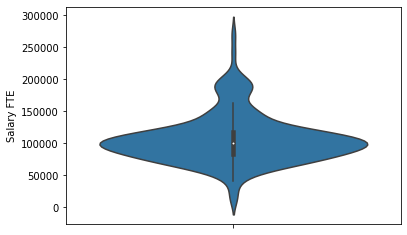

In [82]:
ax = sns.violinplot(y = str_data["Salary FTE"])

In [83]:
str_data["Salary FTE"].describe().round(2)

count       173.00
mean     106469.23
std       37783.65
min       15899.00
25%       83542.00
50%      100000.00
75%      118012.00
max      270600.00
Name: Salary FTE, dtype: float64

Evaluating the distribution of the Salary FTE from the violin plot, there is a moderate positive skew about the data. There are no values that require certain elimination.

## City

Moving to the two categorical variables in the dataset, City and State, there is a requiem to convert these to numerical or boolean features to appease the machine learning method (Random Forest Regressor). The proposed conversion is to a boolean variable that flags whether or not the city is a state capital.

In [84]:
state_capitals = ['Sydney', 'Melbourne', 'Brisbane', 'Adelaide', 'Darwin', 'Canberra', 'Perth', 'Hobart']
def is_capital(string):
  if string in state_capitals:
    return True
  else:
    return False


In [ ]:
str_data["Capital"] = str_data["City"].apply(is_capital)
str_data["Capital"].nunique()

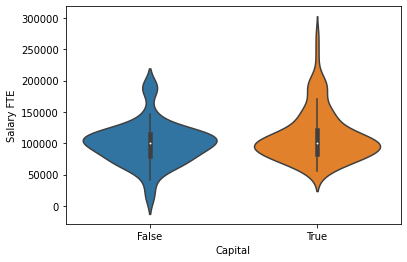

In [86]:
ax = sns.violinplot(x = "Capital", y = "Salary FTE", data = str_data)

There is enough variability demonstrated in the grouped distribution to suggest that there may be some useful signal in the generated boolean feature, especially as Salary FTE increases. 

## State

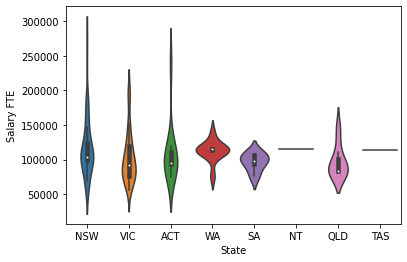

In [88]:
ax = sns.violinplot(x = "State", y = "Salary FTE", data = str_data)

Given there are only eight factors in the State feature, we can opt to create dummy variables to convert the feature to numeric without any loss of signal. The violin plot above demonstrates that high salaries above AUD200,000 are constrained to NSW, VIC and ACT, so this feature should provide benefit to training the model in cases with high salaries.

In [58]:
str_data = pd.get_dummies(str_data, columns = ["State"])

## NLP with Company, Job Title and Description

### NLP Intent

The intent for the natural language processing component is to generate no more than 300 features to capture the signal in the raw data of the text fields. This will be done by performing separate feature extractions on each of the text variables. The rationale for this is to capture corpus specific keywords (not stopwords) in the fields with a short corpus, Company and Job Title, as opposed to allowing the words within to be diluted by the massive Description Corpus. For an example, it is proposed that features such as 'Graduate' and 'Manager' in the Job Title field will be more significant to a machine learning model if their frequency is considered relative to only other terms in their own field. The fields with shorter corpi will naturally be called on for less features compared to the Description field.

### Lemmatizing

The first process in the NLP task is to convert the raw text into particles which the feature extraction programs can easily digest. A similar set of functions to that used in A1 is called upon here to convert the raw text into lemmatized form. This lemmatized form is easily ingested by the scikit-learn feature extractors.

In [90]:
possessives = re.compile("\'s") 
oddchars = re.compile(r"[^\w\s]") 
linebreak = re.compile("\\n")
stopwords = set(stopwords.words('english'))

def text_cleaner(text):
  text = text.lower()
  text = re.sub(possessives, ' ', text)
  text = re.sub(oddchars, ' ', text)
  text = re.sub(linebreak, ' ', text)
  return text

def tokenize_lemmatize(text):
  stem = WordNetLemmatizer()
  tokens = []
  for word in word_tokenize(text):
    if word not in stopwords:
      tokens.append(stem.lemmatize(word))
  return tokens

def rejoiner(text):
  lem_sentence = ""
  for word in text:
    lem_sentence += word
    lem_sentence += " "
  return lem_sentence

def lemmatizer(text):
  clean_text = text_cleaner(text)
  tok_lem_text = tokenize_lemmatize(clean_text)
  lem_text = rejoiner(tok_lem_text)
  return lem_text

In [91]:
str_data["Company"] = str_data["Company"].apply(lemmatizer)
str_data["Job Title"] = str_data["Job Title"].apply(lemmatizer)
str_data["Description"] = str_data["Description"].apply(lemmatizer)

### Company Corpus Visualization

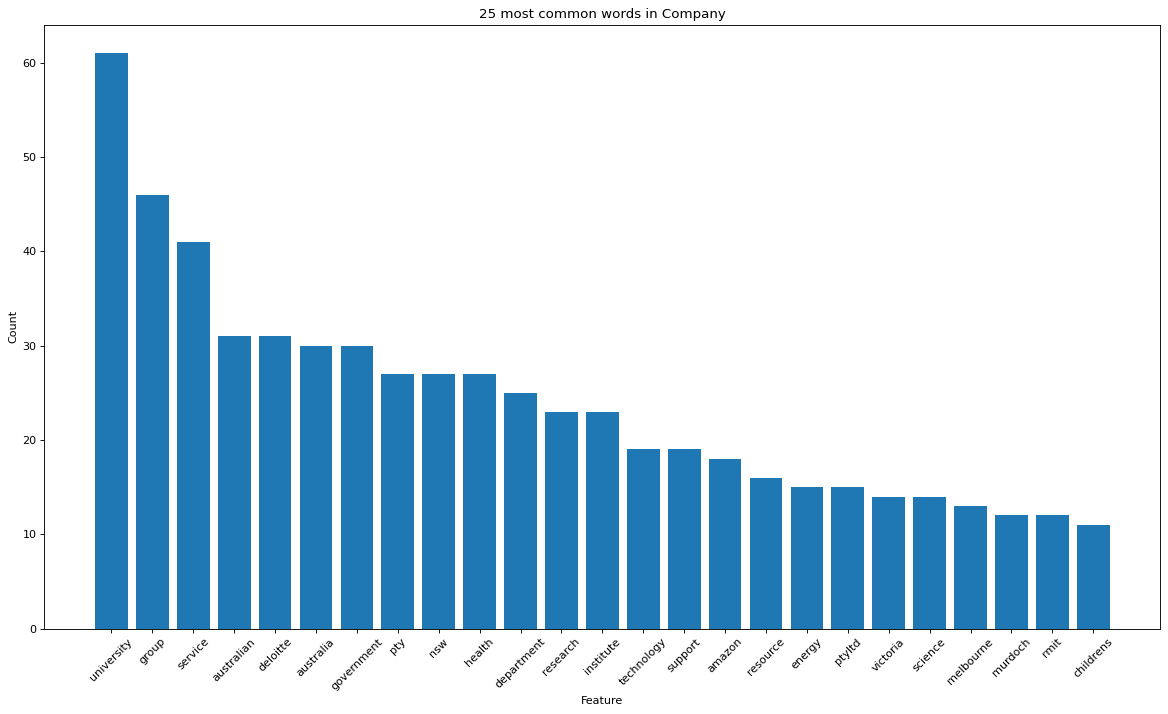

In [92]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words='english')
cv_matrix = cv.fit_transform(str_data['Company'])
total_words = cv_matrix.sum(axis=0) 
freq = [(word, total_words[0, idx]) for word, idx in cv.vocabulary_.items()]
freq = sorted(freq, key = lambda x: x[1], reverse=True)
ngram = pd.DataFrame(freq)
ngram.rename(columns = {0: 'word', 1: 'count'}, inplace = True) 
ngram = ngram.head(25)
plt.figure(figsize=(18, 10), dpi=80)
plt.bar(ngram['word'], ngram['count'])
plt.xticks(rotation = 45)
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title(label = "25 most common words in Company")
plt.show()

The above plot shows the counts of the 25 most common terms in the Company corpus. There are no corpus specific stopwords, with the most common feature "university", appearing in only 7.5% of cases. Furthermore, all of the features visualized have a frequency of greated than 1%, so there is almost certainly some signal in all of the features. Given the intention to not go overboard with the amount of features, 25 is considered an appropriate amount to leverage both data signal and model efficiency. Given the small size of the corpus, CountVectorizer() is an adequate method to extract features, and the pseudo-boolean nature of the features it generates will be efficient in a machine learning environment.

### Company Feature Extraction

In [93]:
feature_extraction_company = CountVectorizer(max_features = 25, ngram_range = (1,1), stop_words = 'english')

In [94]:
feature_company_sparse = feature_extraction_company.fit_transform(str_data['Company'])
feature_company_df = pd.DataFrame.sparse.from_spmatrix(feature_company_sparse)

In [95]:
feature_names_company = list(feature_extraction_company.vocabulary_.keys())
feature_names_company = ['company_' + feature for feature in feature_names_company]
feature_company_df.columns = feature_names_company

### Job Title Corpus Visualization

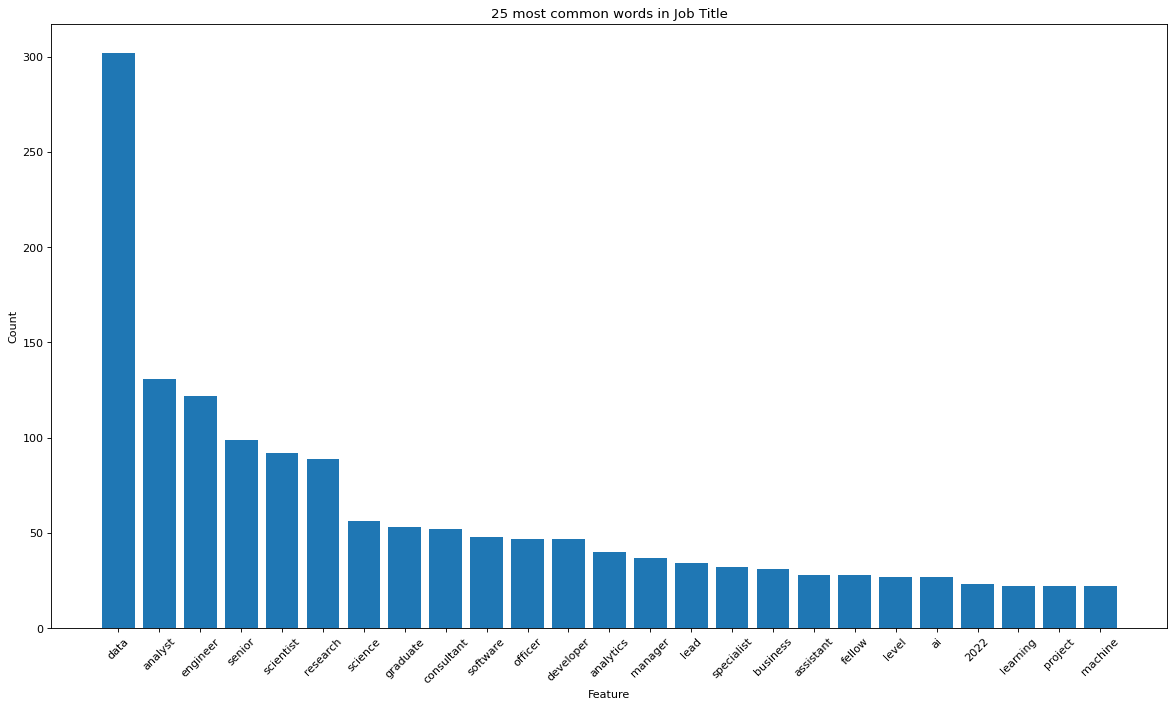

In [96]:
cv = CountVectorizer(ngram_range=(1, 1), stop_words='english')
cv_matrix = cv.fit_transform(str_data['Job Title'])
total_words = cv_matrix.sum(axis=0) 
freq = [(word, total_words[0, idx]) for word, idx in cv.vocabulary_.items()]
freq = sorted(freq, key = lambda x: x[1], reverse=True)
ngram = pd.DataFrame(freq)
ngram.rename(columns = {0: 'word', 1: 'count'}, inplace = True) 
ngram = ngram.head(25)
plt.figure(figsize=(18, 10), dpi=80)
plt.bar(ngram['word'], ngram['count'])
plt.xlabel("Feature")
plt.ylabel("Count")
plt.xticks(rotation = 45)
plt.title(label = "25 most common words in Job Title")
plt.show()

The above plot shows the counts of the 25 most common terms in the Job Title corpus. Desipte being from a similarly sized corpus compared to the Company corpus, there are some differences in the interpretation. First of all, "data" is interpreted as a corpus-specific stopword, and a max_df ceiling will be asserted in feature extraction for exclusion. Secondly, there are features that have much more predictable influence. It is predicted that the presence of features such as "senior", "manager" and "lead" will lead to higher salary predictions. Conversely, the opposite is proposed to be true of features such as "graduate" and "assisstant". With the exception of the exclusion of the feature "data", the same logic applied to the Company field will be applied here, and 24 features will be extracted to pass to the machine learning environment.

### Job Title Feature Extraction

In [ ]:
feature_extraction_title = CountVectorizer(max_features = 24, ngram_range = (1,1), stop_words = 'english', max_df = 0.25)

In [ ]:
feature_title_sparse = feature_extraction_title.fit_transform(str_data['Job Title'])
feature_title_df = pd.DataFrame.sparse.from_spmatrix(feature_title_sparse)

In [ ]:
feature_names_title = list(feature_extraction_title.vocabulary_.keys())
feature_names_title = ['title_' + feature for feature in feature_names_title]
feature_title_df.columns = feature_names_title

### Description Corpus Visualization

Given TfidfVectorizer() is the likely preferred method to extract features for the larger Description corpus, it is important to understand the implications of the ngram_range argument. To achieve this, three visualizations are created to display the 15 most common unigrams, bigrams and trigrams among the corpus.

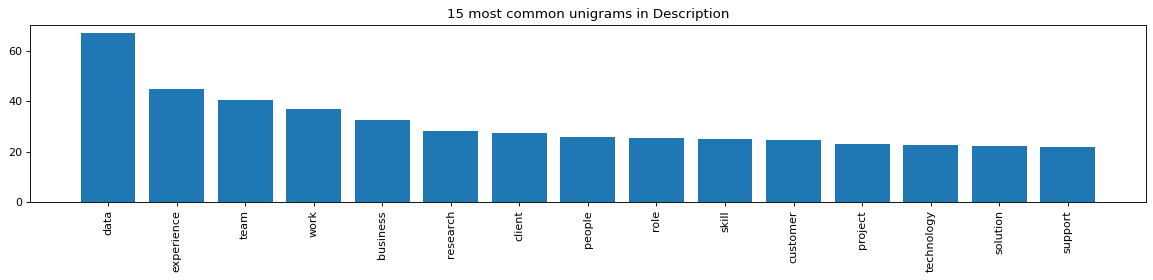

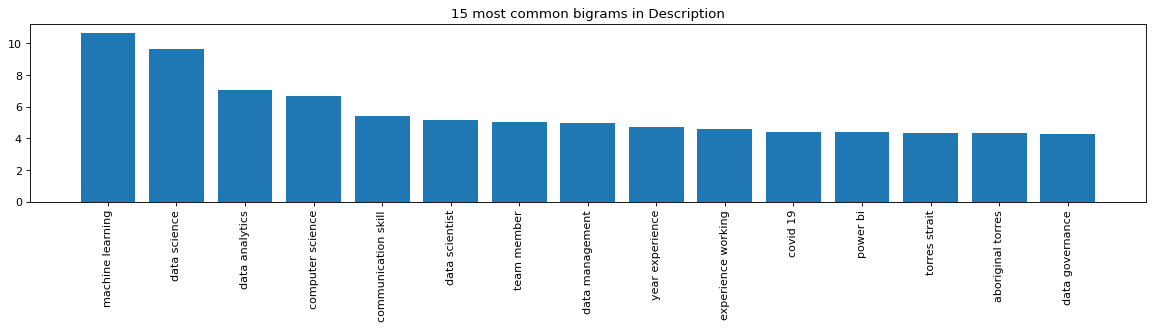

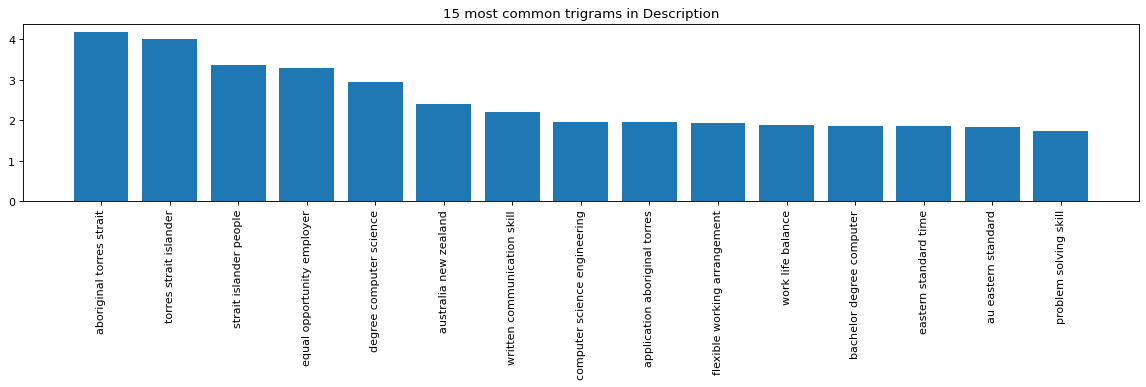

In [ ]:
prefix_dict = {1:'Uni', 2:'Bi', 3:'Tri'}
for n in [1, 2, 3]:
  feature = prefix_dict.get(n) + 'gram'
  tf = TfidfVectorizer(ngram_range=(n, n), stop_words='english')
  tfidf_matrix = tf.fit_transform(str_data['Description'])
  total_words = tfidf_matrix.sum(axis=0) 
  freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
  freq = sorted(freq, key = lambda x: x[1], reverse=True)
  ngram = pd.DataFrame(freq)
  ngram.rename(columns = {0: feature, 1: 'count'}, inplace = True) 
  ngram = ngram.head(15)
  plt.figure(figsize=(18, 10), dpi=80)
  plt.subplot(310+n)
  plt.bar(ngram[feature], ngram['count'])
  plt.title(label = "15 most common " + feature.lower() + "s in Description")
  plt.ylabel("Document Frequency (%)")
  plt.clabel("Feature")
  plt.xticks(rotation = 90)


Assessing the unigram plot, there are some corpus specific stop words that we will need to implement a max_df argument as a means of filtering these out. In terms of the bigrams, it is pleasing to see plenty of features with significant document frequency that will be selected by the extraction. Interestingly, the three most frequent trigrams are combinations of "aboriginal torres strait islander", which may generate some signal concerning corporate responsibility, along with the feature "equal opportunity employer". There is no reason to restrict the feature extractor from accessing features up to trigram in length, so (1,3) is passed to the feature extractor for ngram_range(). 

### Description Feature Extraction

In [ ]:
feature_extraction_description = TfidfVectorizer(max_df = 0.25, min_df = 0.01, ngram_range = (1,3), stop_words = 'english', max_features = 250)

In [ ]:
feature_description_sparse = feature_extraction_description.fit_transform(str_data['Description'])
feature_description_df = pd.DataFrame.sparse.from_spmatrix(feature_description_sparse)

In [ ]:
feature_names_description = list(feature_extraction_description.vocabulary_.keys())
feature_names_description = ['desc_' + feature for feature in feature_names_description]
feature_description_df.columns = feature_names_description

### Data Frame Concatenation

In [ ]:
feature_data = pd.concat([str_data, feature_company_df, feature_title_df, feature_description_df], axis = 1)
feature_data = feature_data.drop(['City', 'Company', 'Job Title', 'Description'], axis = 1)
feature_data.head()

# Output

As was discussed in the webscraper component, checkpointing data outside of the runtime is a sound practice, and is observed again here.

In [ ]:
feature_data.to_excel('feature_data.xlsx')
!cp feature_data.xlsx "drive/My Drive/"

# References

https://stats.oecd.org/index.aspx?DataSetCode=ANHRS

https://www.fairwork.gov.au/starting-employment/types-of-employees/full-time-employees